# SVM performance improvement (choice of the right kernel)


## Importing of libraries

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from time import process_time

## Importing of datasets

In [ ]:
training_set = pd.read_csv("../Datasets/train_mosaic.csv")
test_set = pd.read_csv("../Datasets/test_mosaic.csv")
sdn_set = pd.read_csv("../Datasets/dataset_sdn.csv")
training_set.shape

(809361, 78)

## Data pre-processing 

The main goal here is to select only 1/16 of the dataset in order to see how the NVM model performs in terms of processing time. Moroever, this code also allows to separate the datasets (Training and test set) into two parts (features and labels)

In [ ]:
demi_df_train = training_set.sample(frac=1/16)
demi_df_test = test_set.sample(frac=1/16)
Y_train_3_labels = pd.DataFrame(demi_df_train, columns=["Label"])
X_train = demi_df_train.copy()
del X_train["Label"]
print("Train set",X_train.shape)
Y_test_3_labels = pd.DataFrame(demi_df_test, columns=["Label"])
X_test = demi_df_test.copy()
del X_test["Label"]
print("Test set",X_test.shape)

Train set (50585, 77)
Test set (21679, 77)


There are several labels in this dataset (DoS Hulk, DoS slowloris, BENIGN).Indeed, as we want to predict DDoS attacks we don't really need to differentiate the 2 different types of attacks. As a consequence, the goal here is to process the dataset in order to have only 2 labels available: BENIGN and DDoS

In [ ]:
Y_train = []
Y_test = []
# Processing of the training set
for label in Y_train_3_labels["Label"]:
  if label=="DoS Hulk" or label=="DoS slowloris":
    Y_train.append("DDoS")
  else:
    Y_train.append("BENIGN")

# Processing of the test set
for label in Y_test_3_labels["Label"]:
  if label=="DoS Hulk" or label=="DoS slowloris":
    Y_test.append("DDoS")
  else:
    Y_test.append("BENIGN")
X_train.shape

(50585, 77)

## Noisy data removing

In this part, the main objective is to remove all the non relevant data that could reduce the performance of the machine learning algorithm. The first step is to delete all the features with negative values because it does not make sense in this context.

In [ ]:
del X_train["Init_Win_bytes_backward"]
del X_train["Init_Win_bytes_forward"]
del X_test["Init_Win_bytes_backward"]
del X_test["Init_Win_bytes_forward"]
X_train.shape

(50585, 75)

The next set is to remove the constant features because it means that the values do not have any influence on the model prediction. In fact, whether it is a DDoS attack or not the value still the same.

In [ ]:
index = [32, 33, 49, 55, 56, 57, 58, 59, 60]
for pos in index: 
  feature = X_train.columns[pos]
  del X_train[feature]
  del X_test[feature]
X_train.shape

(50585, 66)

Indeed, we know that SVM algorithm does not perform well with unbalanced dataset. Therefore, we want to verify here the amount of samples for a specific label to determine if it's properly divided. 

In [ ]:
ddos = 0
benign = 0
for value in Y_train:
  if value == "DDoS":
    ddos+=1
  else:
    benign+=1
columns, rows = X_train.shape
print("Total --> ",columns)
print("DDoS --> ",ddos, " | ",ddos*100/columns)
print("BENIGN --> ",benign," | ",benign*100/columns)

Total -->  50585
DDoS -->  27435  |  54.235445290105766
BENIGN -->  23150  |  45.764554709894234


In [ ]:
ddos = 0
benign = 0
for value in Y_test:
  if value == "DDoS":
    ddos+=1
  else:
    benign+=1
columns, rows = X_test.shape
print("Total --> ",columns)
print("DDoS --> ",ddos, " | ",ddos*100/columns)
print("BENIGN --> ",benign," | ",benign*100/columns)

Total -->  21679
DDoS -->  11704  |  53.987730061349694
BENIGN -->  9975  |  46.012269938650306


## Performance Comparison 

The main goal here is to determine if the kernel used influence the performance of the model. 

Firstly, the purpose here is to use the PCA method in order to select the amount of information kept. Secondly, several metrics are measured to determine how the different models perform with the amount information selected. Finally, the measures are ploated on several graphs.

In [ ]:
amoutOfInfo = [0.7,0.8,0.9]
kernels = [ 'poly', 'rbf', 'sigmoid']
featuresMeasured = ["Accuracy","Precision", "Recall", "TPR", "TNR", "FPR" , "FNR", "ProcessingTime"]
amountOfFeature = [1,2,3,7,19,23,27]

measuresInfo = {
    kernel : {} for kernel in kernels
}

for kernel in kernels:
  measuresInfo[kernel] = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "TPR": [],
        "TNR": [],
        "FPR": [],
        "FNR": [],
        "Feature": [],
        "ProcessingTime":[],
    }


for info in amoutOfInfo:
  for kernel in kernels:
    ## feature selection
    print("-------- Experimentation ",kernel," - ",info," --------------")

    ### Train set
    pca = PCA(info)
    X_pca_99 = pca.fit_transform(X_train)
    rows, columns = X_pca_99.shape

    ### Test set
    pca = PCA(columns)
    X_pca_99_test = pca.fit_transform(X_test)
    print("Train_set",X_pca_99.shape)
    print("Test_set",X_pca_99_test.shape)

    ## Model 
    sv_clf = SVC(probability=True,kernel=kernel)
    start = process_time()
    sv_clf.fit(X_pca_99, Y_train)
    end = process_time()
    Y_predict = sv_clf.predict(X_pca_99_test)

    ## Metrix

    ## Processing time
    training_time = end-start

    # accuracy
    accuracy = accuracy_score(Y_test, Y_predict)
    print("Accuracy --> ",accuracy)

    # Precision
    precision = precision_score(Y_test, Y_predict, average='macro')
    print("Precision score --> ",precision)

    # Recall
    recall = recall_score(Y_test, Y_predict, average='macro')
    print("Recall score --> ",recall)


    # Confusion matrix
    matrix = confusion_matrix(Y_test, Y_predict, labels=["DDoS", "BENIGN"])
    print(matrix)

    # TPR, FPR
    FP = matrix[0][0]
    FN = matrix[1][0]
    TP = matrix[1][1]
    TN = matrix[0][1]

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    print("TPR --> ",TPR)
    print("TNR --> ",TNR)
    print("FPR --> ",FPR)
    print("FNR --> ",FNR)
    print("-----------------")

    #Information storage
    measuresInfo[kernel]["Accuracy"].append(accuracy)
    measuresInfo[kernel]["Precision"].append(precision)
    measuresInfo[kernel]["Recall"].append(recall)
    measuresInfo[kernel]["TPR"].append(TPR)
    measuresInfo[kernel]["TNR"].append(TNR)
    measuresInfo[kernel]["FPR"].append(FPR)
    measuresInfo[kernel]["FNR"].append(FNR)
    measuresInfo[kernel]["Feature"].append(columns)
    measuresInfo[kernel]["ProcessingTime"].append(training_time)
    print(measuresInfo)
  

-------- Experimentation  poly  -  0.7  --------------
Train_set (50585, 1)
Test_set (21679, 1)
Accuracy -->  0.5398773006134969
Precision score -->  0.26993865030674846
Recall score -->  0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[11704     0]
 [ 9975     0]]
TPR -->  0.0
TNR -->  0.0
FPR -->  1.0
FNR -->  1.0
-----------------
{'poly': {'Accuracy': [0.5398773006134969], 'Precision': [0.26993865030674846], 'Recall': [0.5], 'TPR': [0.0], 'TNR': [0.0], 'FPR': [1.0], 'FNR': [1.0], 'Feature': [1], 'ProcessingTime': [1127.617038945]}, 'rbf': {'Accuracy': [], 'Precision': [], 'Recall': [], 'TPR': [], 'TNR': [], 'FPR': [], 'FNR': [], 'Feature': [], 'ProcessingTime': []}, 'sigmoid': {'Accuracy': [], 'Precision': [], 'Recall': [], 'TPR': [], 'TNR': [], 'FPR': [], 'FNR': [], 'Feature': [], 'ProcessingTime': []}}
-------- Experimentation  rbf  -  0.7  --------------
Train_set (50585, 1)
Test_set (21679, 1)
Accuracy -->  0.7196365145993819
Precision score -->  0.7428199594160501
Recall score -->  0.7305781499202552
[[6945 4759]
 [1319 8656]]
TPR -->  0.8677694235588972
TNR -->  0.40661312371838687
FPR -->  0.5933868762816131
FNR -->  0.13223057644110275
-----------------
{'poly': {'Accuracy': [0.5398773006134969], 'Precis

Display of the metrics

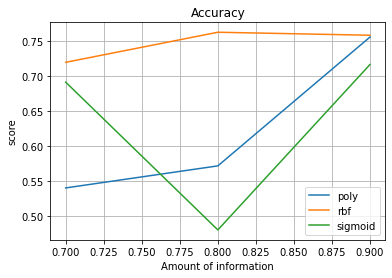

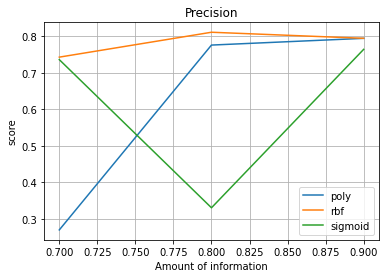

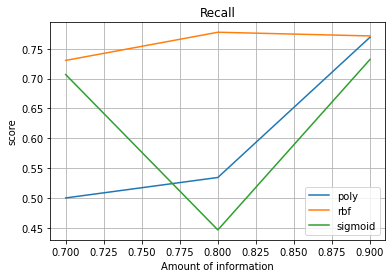

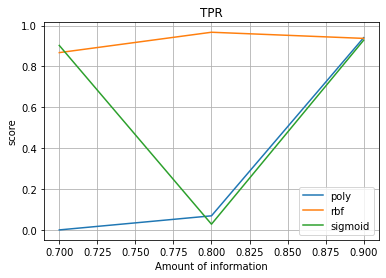

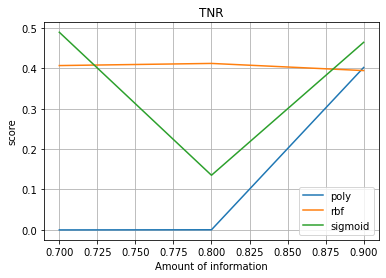

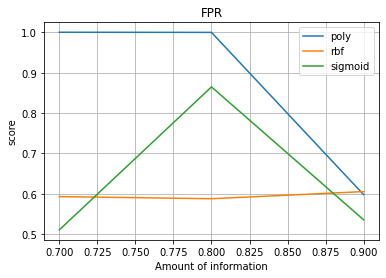

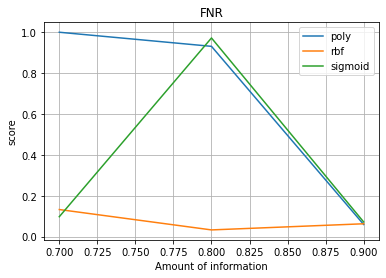

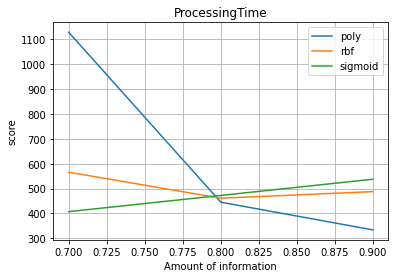

In [ ]:
compteur=0
for feature in featuresMeasured:
  plt.figure(compteur)
  for kernel in kernels:
    plt.plot(amoutOfInfo,measuresInfo[kernel][feature],label=kernel)
  plt.grid(True)
  plt.xlabel("Amount of information")
  plt.ylabel("score")
  plt.legend()
  plt.title(feature)
  chemin = "../Results/SVM/"+feature+".png"
  plt.savefig(chemin)
  compteur+=1